# CLIP Overview and Architecture
CLIP (Contrastive Language-Image Pre-training) represents a breakthrough in multimodal AI that combines **vision** and **text** understanding at internet scale. The model was trained on the Web ImageText (WIT) dataset, which contains 400 million image-text pairs scraped from the internet (comparable to GPT-2).

CLIP's elegant architecture consists of two parallel encoders that transform images and text into the same 512-dimensional vector space, creating what we call embeddings—vector representations that capture semantic meaning.
- **Vision Encoder**: The vision encoder uses either a ResNet-50 convolutional network or a Vision Transformer.
- **Text Encoder**: Text encoder employs a 2-layer transformer with approximately 63 million parameters and 8 attention heads, similar to GPT-2's architecture.

<div align="center">
    <img src="https://www.pareto.si/wp-content/uploads/2023/12/clip_diagram2-1024x528.png" alt="CLIP Architecture" width="800">
</div>

The model learns through **contrastive training** using a loss function that prioritizes:
- Image-text similarity: Maximizes similarity between an image and its corresponding caption while simultaneously minimizing similarity between that image and all other captions in the batch.
- Text-image similarity: Maximizes similarity between a caption and its corresponding image while simultaneously minimizing similarity between that caption and all other images in the batch.

$$\mathcal{L}_{\text{CLIP}} = \frac{1}{2} \left[ \underbrace{-\frac{1}{N} \sum_{i=1}^{N} \log \frac{\exp(\operatorname{sim}(I_i, T_i)/\tau)}{\sum_{j=1}^{N} \exp(\operatorname{sim}(I_i, T_j)/\tau)}}_{\text{image-to-text loss}} - \underbrace{\frac{1}{N} \sum_{i=1}^{N} \log \frac{\exp(\operatorname{sim}(T_i, I_i)/\tau)}{\sum_{j=1}^{N} \exp(\operatorname{sim}(T_i, I_j)/\tau)}}_{\text{text-to-image loss}} \right]$$

where $I_k, T_k$ are the **embeddings** of the image and text, respectively, of the $k$-th sample, and the function $sim()$ is a similarity measure between vectors (typically cosine similarity).

This bidirectional approach enables CLIP to develop robust **zero-shot capabilities**, meaning it can perform many classification tasks without requiring specific training data for those tasks.


### 1.󠀠󠀮󠁽󠁝󠁝󠁝󠁝 Imports and Load Model

In [57]:
from transformers import CLIPProcessor, CLIPModel  # CLIP components for preprocessing and model

import torch                                       # PyTorch library for tensor operations and GPU computations
import torch.nn.functional as F                    # Functional API for neural network operations (activations, loss functions, etc.)

import matplotlib.pyplot as plt                    # Plotting library for visualizations and image display
import seaborn as sns                              # Statistical visualization library
import numpy as np                                 # Numerical computing library

from PIL import Image                              # Python Imaging Library for image loading and processing
import requests                                    # HTTP library for fetching content from URLs
from io import BytesIO


We will load a version of CLIP `openai/clip-vit-base-patch32`. It has the following characteristics.

- **Architecture**: Combines Vision Transformer (ViT) with a text transformer.
- **Model size**: Approximately 82M. Easily fits in a consumer grade GPU.
- **Applications**: Image classification, zero-shot learning, image retrieval, and image captioning.

In [31]:
model_name = "openai/clip-vit-base-patch32"
model = CLIPModel.from_pretrained(model_name)

### 2. Text and Image Preprocessor

Here's an overview of the processor's functionality:

**1. Image Processing**
- **Scaling**: Transforms images to uniform dimensions that the model expects (such as 224x224 pixels).
- **Center Cropping**: Extracts the middle section of images, preserving the main subject as the focus.
- **Format Conversion**: Converts images into PyTorch tensors, the format required by CLIP.
- **Normalization**: Scales pixel values to a standard range, allowing the model to process data efficiently and consistently.

**2. Text Processing**
- **Tokenization**: Splits text labels into individual tokens (words or sub-words).
- **Length Uniformity**: Makes all text sequences the same length by adding padding tokens to shorter sequences or cutting longer ones. This is managed through the `padding=True` parameter.
- **Format Conversionn**: Transforms text tokens into PyTorch tensors using specialized embeddings that work with the CLIP architecture.

**3. Combining Inputs**
- The processor combines the processed image and text tensors into a single dictionary-like object (`inputs`). This object is then passed directly to the CLIP model for prediction.

The CLIP Processor is valuable because it **standardizes** input formatting for reliable predictions, **optimizes computational performance** by handling necessary transformations once rather than repeatedly during inference, and simplifies workflows by abstracting away preprocessing complexities.

In [51]:
# Load a pre-trained CLIP processor for handling images and text preprocessing
processor = CLIPProcessor.from_pretrained(model_name)

# Process Text
texts = ["a pizza slice", "a muffin", "a bicycle", "a dog"]
text_inputs = processor(text=texts, padding=True, return_tensors="pt")

# Process Images
img_sources = ["https://png.pngtree.com/png-vector/20250124/ourmid/pngtree-mouth-watering-pepperoni-pizza-slice-png-image_15317290.png",
               "https://sugargeekshow.com/wp-content/uploads/2019/10/chocolate-chip-muffins-featured.jpg",
               "https://plus.unsplash.com/premium_photo-1678718713393-2b88cde9605b?fm=jpg&q=60&w=3000&ixlib=rb-4.1.0&ixid=M3wxMjA3fDB8MHxzZWFyY2h8MXx8YmljeWNsZXxlbnwwfHwwfHx8MA%3D%3D",
               "https://www.nylabone.com/-/media/project/oneweb/nylabone/images/dog101/10-intelligent-dog-breeds/golden-retriever-tongue-out.jpg?h=430&w=710&hash=7FEB820D235A44B76B271060E03572C7"
]
images = []
headers = {'User-Agent': 'Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36'}
for url in img_sources:
    try:
        response = requests.get(url, headers=headers, timeout=10)
        response.raise_for_status()
        image = Image.open(BytesIO(response.content))
        if image.mode != 'RGB': image = image.convert('RGB')
        images.append(image)
    except requests.exceptions.RequestException as e: print(f"Failed to load {url}: {e}")
image_inputs = processor(images=images, return_tensors="pt")

### 3.󠀠󠀮󠁽󠁝󠁝󠁝󠁝 Text and Image *Embeddings*

In [52]:
# Compute text embeddings without tracking gradients (inference mode)
with torch.no_grad():
    text_embeddings = model.get_text_features(**text_inputs)
with torch.no_grad():
  image_embeddings = model.get_image_features(**image_inputs)


To evaluate how similar or aligned two vectors are, we will use **cosine similarity**, which only looks at the angle they form, ignoring their magnitude.


$$
\operatorname{cosine\_sim}(\mathbf{a}, \mathbf{b}) \;=\; \cos(\theta) \;=\;
\frac{\mathbf{a}\cdot\mathbf{b}}
     {\lVert\mathbf{a}\rVert\,\lVert\mathbf{b}\rVert} \in [-1,+1]
$$
Since it ignores the magnitude of the vectors, it is suitable for comparing texts or images where the angle captures the meaning and the magnitude scales with the number of words or the intensity of the pixels.

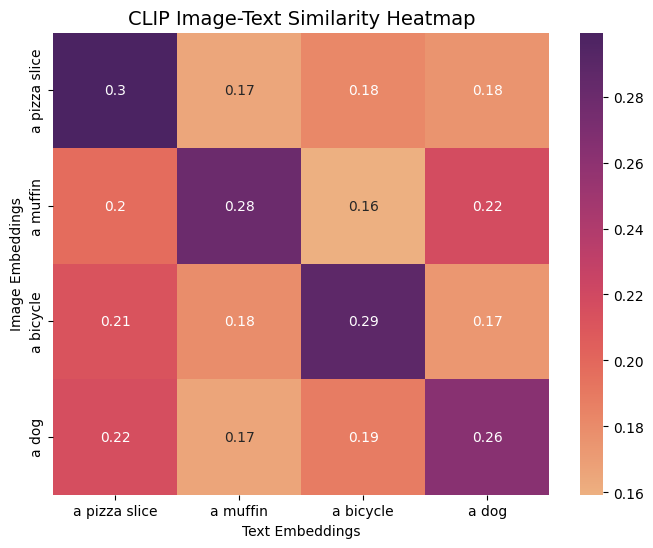

In [56]:
# Compute the cosine similarity matrix between texts and images
similarity = F.cosine_similarity(text_embeddings[:, None, :], image_embeddings[None, :, :], dim=2).cpu().numpy()

# Plot heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(similarity, annot=True, cmap="flare", xticklabels=texts, yticklabels=texts)
plt.xlabel("Text Embeddings")
plt.ylabel("Image Embeddings")
plt.title("CLIP Image-Text Similarity Heatmap", fontsize=14)
plt.show()

### 4. Zero Shot Image Classification

Once the model is pre-trained, we can use it to classify an image into one of a set of predefined classes. These classes are not involved in the training process, which is why it's called *zero-shot* classification. To add more classes we would only need to modify the `texts` variable with the desired classes.

In practice, the preprocessing and computation of text and image embeddings are typically done together in a more streamlined way than previously shown.

In [54]:
# Preprocess the text and image using the CLIP processor
inputs = processor(text=texts, images=images, return_tensors="pt", padding=True)

# Ensure no gradients are calculated for faster inference.
with torch.no_grad():
  outputs = model(**inputs) # Pass the inputs to the model

where

- outputs.**`text_embeds`**:  
  Numerical vectors representing linguistic meaning of each provided text label. These embeddings capture semantic relationships.
- outputs.**`image_embeds`**:  
  Numerical vector representing visual features of each input image, capturing its essential visual characteristics.
- outputs.**`logits_per_image`**:  
  This is the most important part for image classification. It contains similarity scores between the input image and each provided text label. The higher the score, the more similar the image is to that label.

Now we just need to convert these `logits_per_image` into probability distributions (independent for each image), for which we'll apply the softmax function appropriately.

Note: While softmax doesn't change the ordering and isn't strictly necessary for argmax selection, it's useful because it converts raw scores into interpretable probabilities and provides information about model uncertainty.


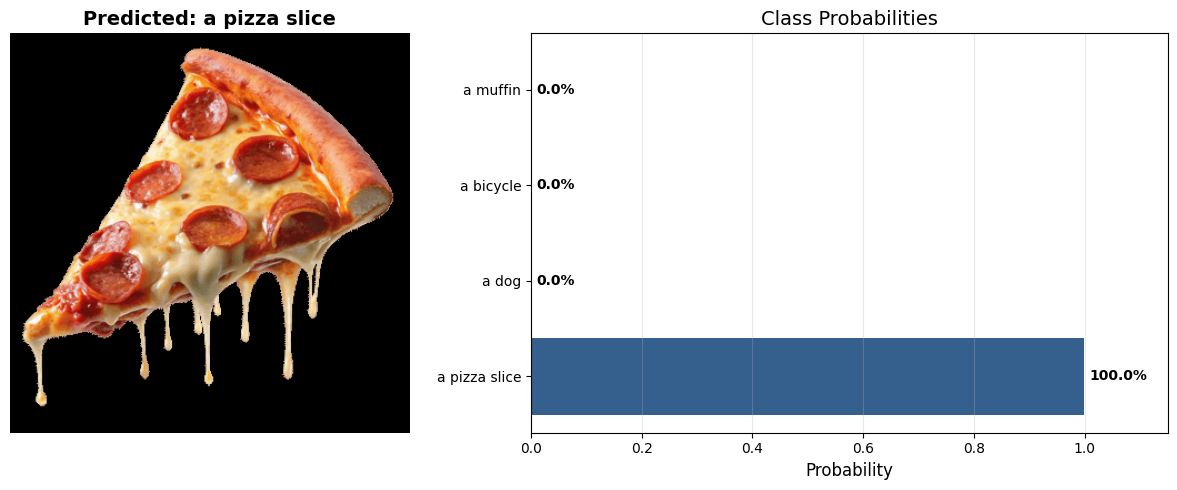

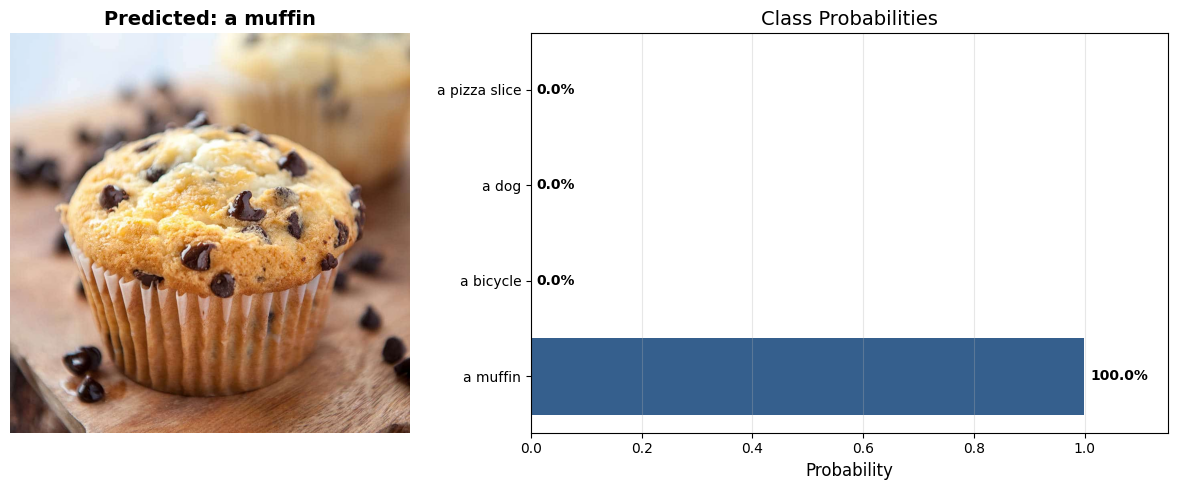

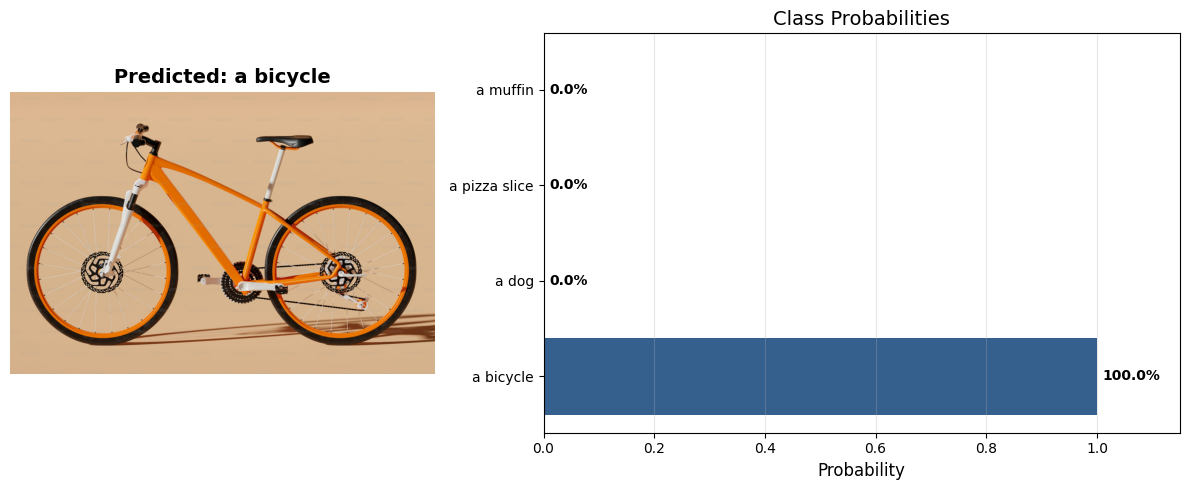

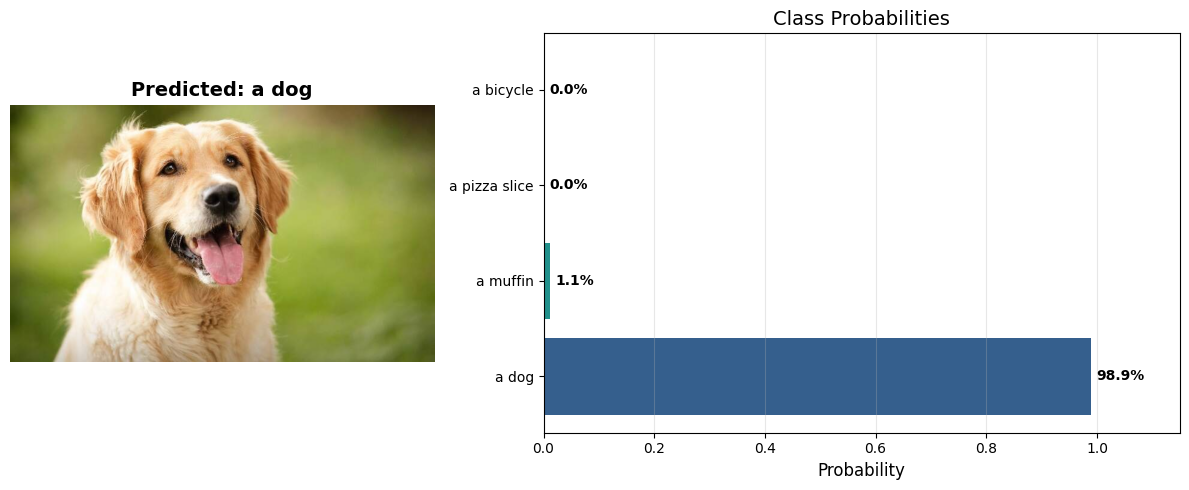

In [58]:
probs = outputs.logits_per_image.softmax(dim=-1) # Apply softmax to get probabilities for each label

# Display the images with their corresponding predicted label and probabilities
for i, image in enumerate(images):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5), gridspec_kw={'width_ratios': [2, 3]})

    # Display image
    ax1.imshow(image)
    ax1.axis('off')
    ax1.set_title(f"Predicted: {texts[probs[i].argmax()]}", fontsize=14, fontweight='bold')

    # Display probabilities as horizontal bar chart
    probabilities = probs[i].cpu().numpy()
    sorted_indices = np.argsort(probabilities)[::-1]

    colors = plt.cm.viridis(np.linspace(0.3, 0.9, len(texts)))
    bars = ax2.barh(range(len(texts)), probabilities[sorted_indices], color=colors)

    # Add percentage labels on bars
    for j, (idx, bar) in enumerate(zip(sorted_indices, bars)):
        width = bar.get_width()
        ax2.text(width + 0.01, bar.get_y() + bar.get_height()/2,
                f'{probabilities[idx]:.1%}', ha='left', va='center', fontweight='bold')

    ax2.set_yticks(range(len(texts)))
    ax2.set_yticklabels([texts[idx] for idx in sorted_indices])
    ax2.set_xlabel('Probability', fontsize=12)
    ax2.set_xlim(0, 1.15)
    ax2.grid(axis='x', alpha=0.3)
    ax2.set_title('Class Probabilities', fontsize=14)

    plt.tight_layout()
    plt.show()